In [1]:
#import transformers
import os
import re
import string
import pandas as pd
#import torch
#from huggingface_hub import notebook_login
#from transformers import pipeline
#from transformers import AutoTokenizer, AutoModelForSequenceClassification, AutoModel

In [2]:
# nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stoplist=stopwords.words('english')
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer= WordNetLemmatizer()
from nltk.corpus import wordnet

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('omw-1.4')

# Importing gensim related libraries
import gensim
from gensim.models.ldamulticore import LdaMulticore
from gensim.corpora import Dictionary
from gensim.models import Phrases
from collections import Counter
from gensim.models import Word2Vec

[nltk_data] Downloading package stopwords to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /mnt/ceph/storage/data-tmp/teaching-
[nltk_data]     current//aq60qovu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /mnt/ceph/storage/data-
[nltk_data]     tmp/teaching-current//aq60qovu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [3]:
df_orig = pd.read_csv('../../datasets/future_statements_dataset/future_dataset.csv', sep='|')

In [4]:
df_orig.columns

Index(['statement', 'future', 'source'], dtype='object')

In [7]:
def get_pos_tag(tag):
    """This function is used to get the part-of-speech(POS) for lemmatization"""
    if tag.startswith('N') or tag.startswith('J'):
        return wordnet.NOUN
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN #default case

def preprocess(text):
    """ 1. Removes Punctuations
        2. Removes words smaller than 3 letters
        3. Converts into lowercase
        4. Lemmatizes words
        5. Removes Stopwords
    """   
    punctuation= list(string.punctuation)
    doc_tokens= nltk.word_tokenize(text)
    word_tokens= [word.lower() for word in doc_tokens if not (word in punctuation or len(word)<=3)]
    
    # Lemmatize    
    pos_tags=nltk.pos_tag(word_tokens)
    doc_words=[wordnet_lemmatizer.lemmatize(word, pos=get_pos_tag(tag)) for word, tag in pos_tags]
    doc_words= [word for word in doc_words if word not in stoplist]
    
    return doc_words

df_clean = df_orig['statement'].apply(preprocess)
df_clean.head()

0    [need, rededicate, principle, purpose, organiz...
1     [many, thing, leave, behind, many, thing, await]
2    [philippine, stand, ready, assist, implement, ...
3    [first, indigenous, population, paraguay, larg...
4    [also, grateful, principled, position, home, m...
Name: statement, dtype: object

In [20]:
docs= list(df_clean)
phrases = gensim.models.Phrases(docs, min_count=10, threshold=20)
bigram_model = gensim.models.phrases.Phraser(phrases)

In [21]:
def make_bigrams(texts):
    return [bigram_model[doc] for doc in texts]

# Form Bigrams
data_words_bigrams = make_bigrams(docs)

In [40]:
# Checkout most frequent bigrams :
bigram_counter1= Counter()
for key in phrases.vocab.keys():
    if key not in stopwords.words('english'):
        if len(str(key).split('_'))>1:
            bigram_counter1[key]+=phrases.vocab[key]

for key, counts in bigram_counter1.most_common(20):
    print(key,"---", counts)

united_nation --- 100
international_community --- 38
security_council --- 31
general_assembly --- 29
unite_nation --- 24
develop_country --- 22
next_year --- 20
climate_change --- 19
last_year --- 19
peace_security --- 17
past_year --- 14
human_right --- 14
united_state --- 13
first_time --- 12
take_place --- 12
elon_musk --- 12
supply_chain --- 12
council_resolution --- 11
middle_east --- 10
five_year --- 10


In [23]:
#modelstep: Feeding the bigrams into a Word2Vec model produces more meaningful bigrams

w2vmodel = Word2Vec(sentences=bigram_model[docs], vector_size=100, sg=1, hs= 1, seed=33)
bigram_counter = Counter()

for key in w2vmodel.wv.key_to_index.keys(): #deprecated: w2vmodel.wv.vocab.keys()
    if key not in stoplist:
        if len(str(key).split("_")) > 1:
            #print(list(w2vmodel.wv.index_to_key).count())
            #bigram_counter[key] += list(w2vmodel.wv.index_to_key).count()
            #bigram_counter[key] += w2vmodel.wv.vocab[key].count
            bigram_counter[key] += w2vmodel.wv.get_vecattr(key, "count")

for key, counts in bigram_counter.most_common(50):
    print(key,">>>>> " ,counts)

united_nation >>>>>  100
international_community >>>>>  38
security_council >>>>>  31
general_assembly >>>>>  29
unite_nation >>>>>  24
develop_country >>>>>  22
next_year >>>>>  20
climate_change >>>>>  19
last_year >>>>>  19
peace_security >>>>>  17
human_right >>>>>  14
supply_chain >>>>>  12
elon_musk >>>>>  12


In [41]:
w2vmodel.wv.most_similar(positive=['climate_change'], topn=2)

[('engage', 0.9926280975341797), ('2030', 0.9922609925270081)]

In [82]:
#w2vmodel.wv.most_similar(['next_year','supply_chain'], ['last_year'], topn=5)

In [42]:
#Example for network graph
#The future of climate change will be bad | climate change | engage, 2030

In [ ]:
w2vmodel.wv.most_similar(positive=['artificial_intelligence'])

In [39]:
#Create a dictionary and corpus for input to our LDA model
#Filter out the most common and uncommon words

dictionary= Dictionary(data_words_bigrams)
print('Number of unique tokens (before filter): %d' % len(dictionary))

# Filter out words that occur less than 20 documents, or more than 50% of the documents.
dictionary.filter_extremes(no_below=20, no_above=0.6)
corpus = [dictionary.doc2bow(doc) for doc in docs]

print('Number of unique tokens (after filter): %d' % len(dictionary))
print('Number of documents: %d' % len(corpus))

Number of unique tokens (before filter): 6302
Number of unique tokens (after filter): 274
Number of documents: 2500


In [45]:
#train LDA model/topic model

from gensim.models.ldamulticore import LdaMulticore
import time
import numpy as np

t0= time.time()
passes= 150
np.random.seed(1) # setting up random seed to get the same results
num_topics
ldamodel= LdaMulticore(corpus, 
                    id2word=dictionary, 
                    num_topics=num_topics, 
#                   alpha='asymmetric', 
                    chunksize= 4000, 
                    batch= True,
                    minimum_probability=0.001,
                    iterations=350,
                    passes=passes)                    

t1= time.time()
print("time for",passes," passes: ",(t1-t0)," seconds")

time for 150  passes:  386.54116129875183  seconds


In [70]:
first_topic = ldamodel.show_topics(num_words=25, formatted=False)[0][1]
second_topic = ldamodel.show_topics(num_words=25, formatted=False)[1][1]
third_topic = ldamodel.show_topics(num_words=25, formatted=False)[2][1]
forth_topic = ldamodel.show_topics(num_words=25, formatted=False)[3][1]

In [71]:
[item[0] for item in second_topic]

['nation',
 'united',
 'international',
 'country',
 'government',
 'people',
 'problem',
 'world',
 'make',
 'peace',
 'security',
 'development',
 'result',
 'economic',
 'state',
 'issue',
 'community',
 'challenge',
 'progress',
 'effort',
 'political',
 'ensure',
 'action',
 'support',
 'achieve']

In [48]:
#Storing the major topic
lda_corpus= ldamodel[corpus]

In [52]:
# Obtaining the main topic for each review:
all_topics = ldamodel.get_document_topics(corpus)
num_docs = len(all_topics)

all_topics_csr= gensim.matutils.corpus2csc(all_topics)
all_topics_numpy= all_topics_csr.T.toarray()

major_topic= [np.argmax(arr) for arr in all_topics_numpy]
df_orig['major_lda_topic']= major_topic

In [72]:
import seaborn as sns

<AxesSubplot:>

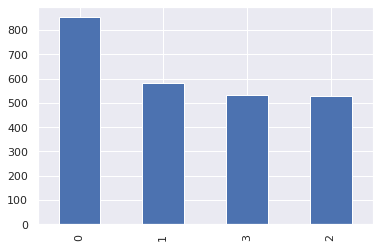

In [73]:
#distribution of topics in statements

sns.set(rc= {'figure.figsize': (5,3)})
sns.set_style('darkgrid')

df_orig.major_lda_topic.value_counts().plot(kind='bar')

In [84]:
"""
import os
import openai

openai.api_key = os.getenv("OPENAI_API_KEY")

response = openai.Completion.create(
  model="text-davinci-002",
  prompt="Topic (of maximum 2 Words) for these keywords:\n\"\"\"\n'nation',\n 'united',\n 'international',\n 'country',\n 'government',\n 'people',\n 'problem',\n 'world',\n 'make',\n 'peace',\n 'security',\n 'development',\n 'result',\n 'economic',\n 'state',\n 'issue',\n 'community',\n 'challenge',\n 'progress',\n 'effort',\n 'political',\n 'ensure',\n 'action',\n 'support',\n 'achieve'\n\"\"\"\nis:",
  temperature=0.7,
  max_tokens=256,
  top_p=1,
  frequency_penalty=0,
  presence_penalty=0,
  stop=["\"\"\""]
)
"""

'\nimport os\nimport openai\n\nopenai.api_key = os.getenv("OPENAI_API_KEY")\n\nresponse = openai.Completion.create(\n  model="text-davinci-002",\n  prompt="Topic (of maximum 2 Words) for these keywords:\n"""\n\'nation\',\n \'united\',\n \'international\',\n \'country\',\n \'government\',\n \'people\',\n \'problem\',\n \'world\',\n \'make\',\n \'peace\',\n \'security\',\n \'development\',\n \'result\',\n \'economic\',\n \'state\',\n \'issue\',\n \'community\',\n \'challenge\',\n \'progress\',\n \'effort\',\n \'political\',\n \'ensure\',\n \'action\',\n \'support\',\n \'achieve\'\n"""\nis:",\n  temperature=0.7,\n  max_tokens=256,\n  top_p=1,\n  frequency_penalty=0,\n  presence_penalty=0,\n  stop=["""""]\n)\n'